# Installing dependencies

In [1]:
%%capture
!pip install git+https://github.com/nickkunz/smogn.git

# Importing libraries and frameworks

In [2]:
# General python libraries to arrange dataset and plot graphs
import re
import smogn
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import cov
from numpy import loadtxt
from matplotlib import pyplot

# Data pre-processing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Downloading images
from google.colab import files

# Measure of accuracy
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale 

# Importing the Random Forest libraries for regression and feature selection
from sklearn.ensemble import RandomForestRegressor

# Importing the Linear Regression libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

# importing SVM Libraries
from sklearn.svm import SVR

# ANN for regression
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Importing the dataset

In [3]:
# Import dataset
df = pd.read_csv("/content/sample_data/dataset.csv")

In [4]:
df.head()

,Name,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time,Speedup
0,matrix_multiplication,1,simsmall,143684436,0.21,65664709,48.300,135952510,9.253340e+09,6.198231e+09,0.67,3943.67,2413,3.284836e+09,50053,65551272,3.767890,1.000000
1,matrix_multiplication,2,simsmall,279763702,0.11,65929676,48.569,135743873,8.216107e+09,6.355125e+09,0.77,3519.53,2772,3.159218e+09,33541,65901746,1.844048,2.043271
2,matrix_multiplication,4,simsmall,283327885,0.10,67158355,49.254,136349806,8.644179e+09,6.353836e+09,0.74,3702.91,1776,3.177617e+09,10434,66861668,0.990931,3.802374
3,matrix_multiplication,8,simsmall,287638885,0.10,73962101,54.350,136084681,8.914081e+09,6.393717e+09,0.72,3806.00,1788,3.218620e+09,10216,73898040,0.552178,6.823685
4,matrix_multiplication,16,simsmall,300239815,0.10,76271406,56.012,136169963,9.009864e+09,6.419541e+09,0.71,3854.19,1813,3.230948e+09,40422,76265372,0.271104,13.898327


In [5]:
df = df[df.columns[1:18]]

In [6]:
df.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time,Speedup
0,1,simsmall,143684436,0.21,65664709,48.300,135952510,9.253340e+09,6.198231e+09,0.67,3943.67,2413,3.284836e+09,50053,65551272,3.767890,1.000000
1,2,simsmall,279763702,0.11,65929676,48.569,135743873,8.216107e+09,6.355125e+09,0.77,3519.53,2772,3.159218e+09,33541,65901746,1.844048,2.043271
2,4,simsmall,283327885,0.10,67158355,49.254,136349806,8.644179e+09,6.353836e+09,0.74,3702.91,1776,3.177617e+09,10434,66861668,0.990931,3.802374
3,8,simsmall,287638885,0.10,73962101,54.350,136084681,8.914081e+09,6.393717e+09,0.72,3806.00,1788,3.218620e+09,10216,73898040,0.552178,6.823685
4,16,simsmall,300239815,0.10,76271406,56.012,136169963,9.009864e+09,6.419541e+09,0.71,3854.19,1813,3.230948e+09,40422,76265372,0.271104,13.898327


In [7]:
df["Size"] = OrdinalEncoder().fit_transform(df[["Size"]])
df.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time,Speedup
0,1,2.0,143684436,0.21,65664709,48.300,135952510,9.253340e+09,6.198231e+09,0.67,3943.67,2413,3.284836e+09,50053,65551272,3.767890,1.000000
1,2,2.0,279763702,0.11,65929676,48.569,135743873,8.216107e+09,6.355125e+09,0.77,3519.53,2772,3.159218e+09,33541,65901746,1.844048,2.043271
2,4,2.0,283327885,0.10,67158355,49.254,136349806,8.644179e+09,6.353836e+09,0.74,3702.91,1776,3.177617e+09,10434,66861668,0.990931,3.802374
3,8,2.0,287638885,0.10,73962101,54.350,136084681,8.914081e+09,6.393717e+09,0.72,3806.00,1788,3.218620e+09,10216,73898040,0.552178,6.823685
4,16,2.0,300239815,0.10,76271406,56.012,136169963,9.009864e+09,6.419541e+09,0.71,3854.19,1813,3.230948e+09,40422,76265372,0.271104,13.898327


# Pre-processing

In [8]:
## conduct smogn
df_smogn = smogn.smoter(
    data = df,  ## pandas dataframe
    y = 'Speedup'  ## string ('header name')
)

r_index: 100%|##########| 40/40 [00:00<00:00, 351.03it/s]


In [9]:
df.shape

(316, 17)

In [10]:
df_smogn.reset_index(drop=True, inplace=True)
df_smogn.shape

(329, 17)

In [11]:
df_smogn.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time,Speedup
0,7,1.881804,370235406,4.527045,9047670,10.449487,86562301,4.284279e+09,1.742331e+09,0.409409,1877.194947,135667,9.024817e+08,45235211,9083164,0.012118,5.964286
1,7,2.000000,363184542,4.643208,8872102,9.800576,90521796,3.978546e+09,1.783278e+09,0.449321,1730.301477,129820,9.230582e+08,48358184,9258039,0.010023,8.736364
2,7,0.183782,386381749,4.413784,9746879,10.379151,93909804,4.270503e+09,1.763770e+09,0.410000,1860.418295,135594,9.249878e+08,49103508,9107829,0.067935,9.425676
3,8,2.000000,101790609,0.020000,138506,35.457418,402702,5.112790e+08,3.828358e+08,0.750000,297.867287,745,1.618865e+08,81538,83345,4.403387,17.389727
4,2,1.000000,1551134029,2.722528,9253721,5.136830,179880974,1.449018e+10,9.636727e+09,0.668482,6281.160895,136591,4.431493e+09,57932948,9114520,2.074745,4.908413


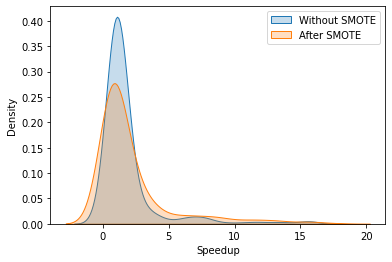

In [12]:
sns.kdeplot(df['Speedup'], fill=True, palette="crest", label = "Without SMOTE", legend=True)
sns.kdeplot(df_smogn['Speedup'], fill=True, palette="crest", label = "After SMOTE", legend=True)
plt.legend()

In [14]:
# Split data into X(Conditional variables) and Y(Output variable)
X = df.iloc[:, 0:16 ]
X_smogn = df_smogn.iloc[:, 0:16]

# Execution time is the output variable. If we can predict the exe-time, we can predict the speedup.
Y = df.loc[:, ['Speedup']]
Y_smogn = df_smogn.loc[:, ['Speedup']]

In [15]:
X.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time
0,7,1.881804,370235406,4.527045,9047670,10.449487,86562301,4.284279e+09,1.742331e+09,0.409409,1877.194947,135667,9.024817e+08,45235211,9083164,0.012118
1,7,2.000000,363184542,4.643208,8872102,9.800576,90521796,3.978546e+09,1.783278e+09,0.449321,1730.301477,129820,9.230582e+08,48358184,9258039,0.010023
2,7,0.183782,386381749,4.413784,9746879,10.379151,93909804,4.270503e+09,1.763770e+09,0.410000,1860.418295,135594,9.249878e+08,49103508,9107829,0.067935
3,8,2.000000,101790609,0.020000,138506,35.457418,402702,5.112790e+08,3.828358e+08,0.750000,297.867287,745,1.618865e+08,81538,83345,4.403387
4,2,1.000000,1551134029,2.722528,9253721,5.136830,179880974,1.449018e+10,9.636727e+09,0.668482,6281.160895,136591,4.431493e+09,57932948,9114520,2.074745


In [16]:
Y['Speedup']

0       5.964286
1       8.736364
2       9.425676
3      17.389727
4       4.908413
         ...    
324     0.792857
325     0.402649
326     0.344828
327     0.826984
328     0.406091
Name: Speedup, Length: 329, dtype: float64

In [17]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.2, random_state = 5)
X_train_smogn, X_valid_smogn, Y_train_smogn, Y_valid_smogn = train_test_split(X_smogn, Y_smogn, test_size = 0.2, random_state = 5)

In [18]:
X_train.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time
327,7,1.024183,372749616,4.539033,9749467,10.563879,92273773,4.217544e+09,1.832561e+09,0.439033,1830.873678,136183,9.367349e+08,47623878,9235674,0.034589
223,2,2.000000,641528431,3.550000,8461273,7.592000,111450302,7.486504e+09,3.629922e+09,0.480000,3249.580000,136406,1.754824e+09,46791548,7624619,0.736000
123,8,0.000000,5277772819,2.940000,14932578,25.798000,57883453,2.844316e+10,3.244002e+10,1.140000,11995.135580,116339,9.811985e+09,8052508,13046561,3.664033
261,16,1.625606,109356978,2.013889,32018,0.700334,6160874,1.001145e+09,6.238561e+08,0.587439,463.819485,109,2.101422e+08,3984696,51548,0.126829
191,8,0.000000,375272050,4.230000,7575626,8.936000,84771736,4.072865e+09,1.735370e+09,0.430000,1771.920000,130279,8.968208e+08,40297067,7480045,0.093000


In [19]:
linreg = LinearRegression().fit(X_train, Y_train)
Y_pred = linreg.predict(X_valid)
print('R-squared score Validation: ', r2_score(Y_valid, Y_pred))
print('Linear Regression validation MAE: ', mae(Y_valid , Y_pred))

R-squared score Validation:  0.2032427216431395
Linear Regression validation MAE:  1.7178180955660325


In [20]:
linreg_smogn = LinearRegression().fit(X_train_smogn, Y_train_smogn)
Y_pred_smogn = linreg_smogn.predict(X_valid_smogn)
print('R-squared score Validation: ', r2_score(Y_valid_smogn, Y_pred_smogn))
print('Linear Regression validation MAE: ', mae(Y_valid_smogn , Y_pred_smogn))

R-squared score Validation:  0.23188206642899212
Linear Regression validation MAE:  0.9623703369636062


In [21]:
lassocv = LassoCV(cv = 10, max_iter = 10000, normalize = True).fit(X_train, Y_train)
Y_pred = lassocv.predict(X_valid)
print('R-squared score (Validation): ', r2_score(Y_valid, Y_pred))
print('Linear Regression validation MAE: ', mae(Y_valid , Y_pred))

R-squared score (Validation):  0.4468971089983089
Linear Regression validation MAE:  1.6048599860342245


In [22]:
lassocv_smogn = LassoCV(cv = 10, max_iter = 10000, normalize = True).fit(X_train_smogn, Y_train_smogn)
Y_pred_smogn = lassocv_smogn.predict(X_valid_smogn)
print('R-squared score (Validation): ', r2_score(Y_valid_smogn, Y_pred_smogn))
print('Linear Regression validation MAE: ', mae(Y_valid_smogn, Y_pred_smogn))

R-squared score (Validation):  0.19734774823765877
Linear Regression validation MAE:  0.9720777719026186


In [23]:
ridgecv = RidgeCV(cv = 10, normalize = True).fit(X_train, Y_train)
Y_pred = ridgecv.predict(X_valid)
print('R-squared score (Validation): ', r2_score(Y_valid, Y_pred))
print('Linear Regression validation MAE: ', mae(Y_valid , Y_pred))

R-squared score (Validation):  0.2394946833279853
Linear Regression validation MAE:  1.7829396469669472


In [24]:
ridgecv_smogn = RidgeCV(cv = 10, normalize = True).fit(X_train_smogn, Y_train_smogn)
Y_pred_smogn = ridgecv_smogn.predict(X_valid_smogn)
print('R-squared score (Validation): ', r2_score(Y_valid_smogn, Y_pred_smogn))
print('Linear Regression validation MAE: ', mae(Y_valid_smogn, Y_pred_smogn))

R-squared score (Validation):  0.15532157319164608
Linear Regression validation MAE:  0.8967486976293354


In [25]:
svr = SVR(kernel='rbf', C = 10, epsilon = 10).fit(X_train, Y_train)
Y_pred = svr.predict(X_valid)
print('R-squared score (Validation): ', r2_score(Y_valid, Y_pred))
print('Linear Regression validation MAE: ', mae(Y_valid , Y_pred))

R-squared score (Validation):  -5.540631868834507
Linear Regression validation MAE:  7.181773931720818


In [26]:
svr_smogn = SVR(kernel='rbf', C = 10, epsilon = 10).fit(X_train_smogn, Y_train_smogn)
Y_pred_smogn = svr_smogn.predict(X_valid_smogn)
print('R-squared score (Validation): ', r2_score(Y_valid_smogn, Y_pred_smogn))
print('Linear Regression validation MAE: ', mae(Y_valid_smogn, Y_pred_smogn))

R-squared score (Validation):  -10.117175932519158
Linear Regression validation MAE:  6.616465010109375


In [27]:
forest = RandomForestRegressor().fit(X_train, Y_train)
Y_pred = forest.predict(X_valid)
print('R-squared score (Validation): ', r2_score(Y_valid, Y_pred))
print('Linear Regression validation MAE: ', mae(Y_valid , Y_pred))

R-squared score (Validation):  0.5858575712615045
Linear Regression validation MAE:  1.0350493832523529


In [28]:
forest_smogn = RandomForestRegressor().fit(X_train_smogn, Y_train_smogn)
Y_pred_smogn = forest_smogn.predict(X_valid_smogn)
print('R-squared score (Validation): ', r2_score(Y_valid_smogn, Y_pred_smogn))
print('Linear Regression validation MAE: ', mae(Y_valid_smogn, Y_pred_smogn))

R-squared score (Validation):  0.5777225813665736
Linear Regression validation MAE:  0.7270991590509374


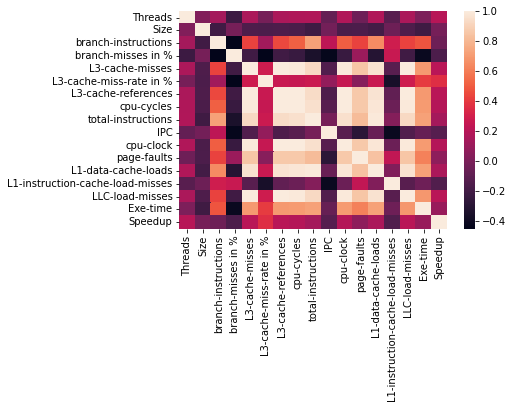

In [29]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix);

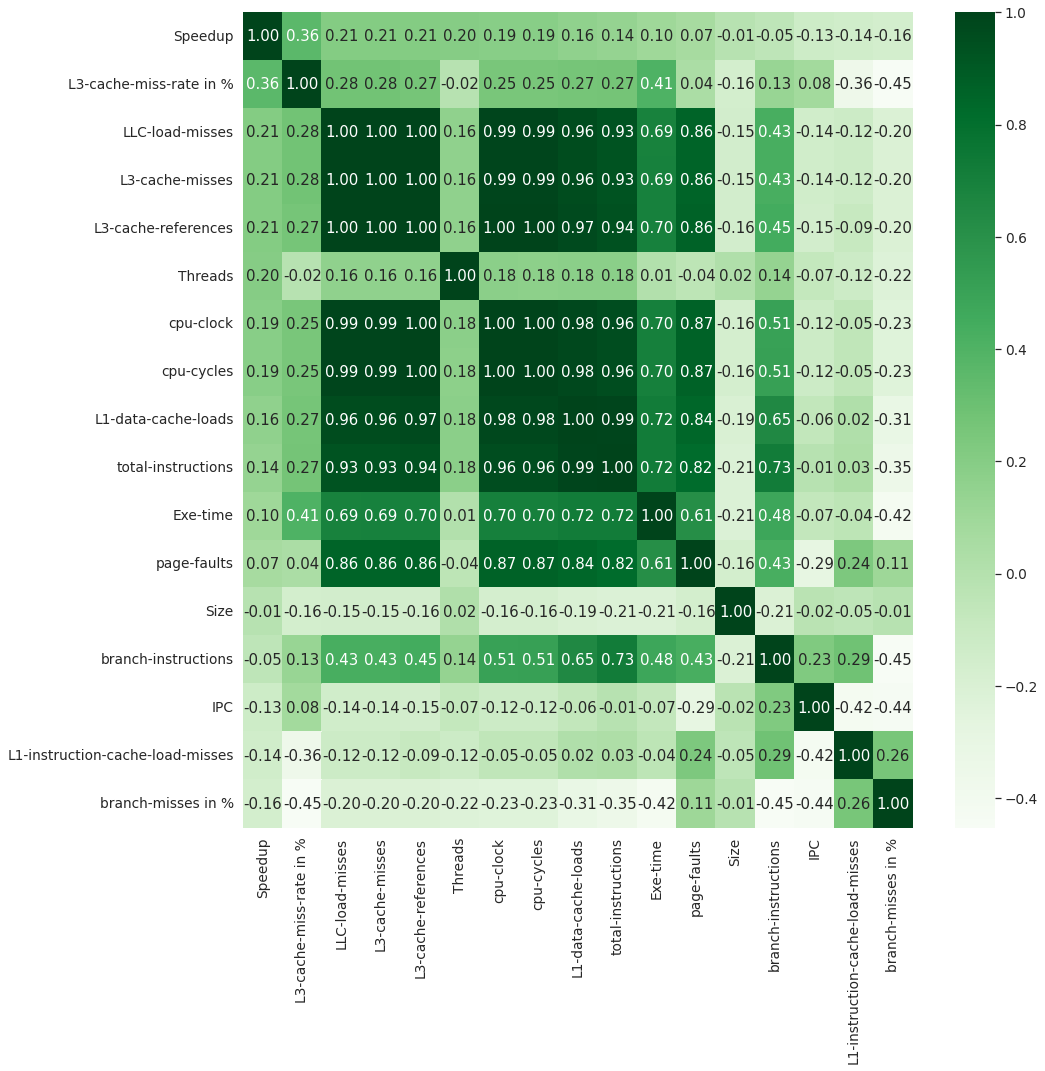

In [30]:
k = 17
cols = corr_matrix.nlargest(k, 'Speedup').index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(cm, cmap="Greens", annot=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)
plt.show()

In [31]:
# pca = PCA(n_components = 10)
# pca = pca.fit(X)
# pca_ = pca.transform(X, columns = X.columns)

In [32]:
cols[1:6]

Index(['L3-cache-miss-rate in %', 'LLC-load-misses', 'L3-cache-misses',
       'L3-cache-references', 'Threads'],
      dtype='object')

In [33]:
df[cols[1:6]]

,L3-cache-miss-rate in %,LLC-load-misses,L3-cache-misses,L3-cache-references,Threads
0,10.449487,9083164,9047670,86562301,7
1,9.800576,9258039,8872102,90521796,7
2,10.379151,9107829,9746879,93909804,7
3,35.457418,83345,138506,402702,8
4,5.136830,9114520,9253721,179880974,2
...,...,...,...,...,...
324,10.580639,9229494,9722742,91879273,8
325,9.873712,8522963,8990271,90822200,8
326,9.846910,7963788,8443100,85780500,6
327,10.563879,9235674,9749467,92273773,7


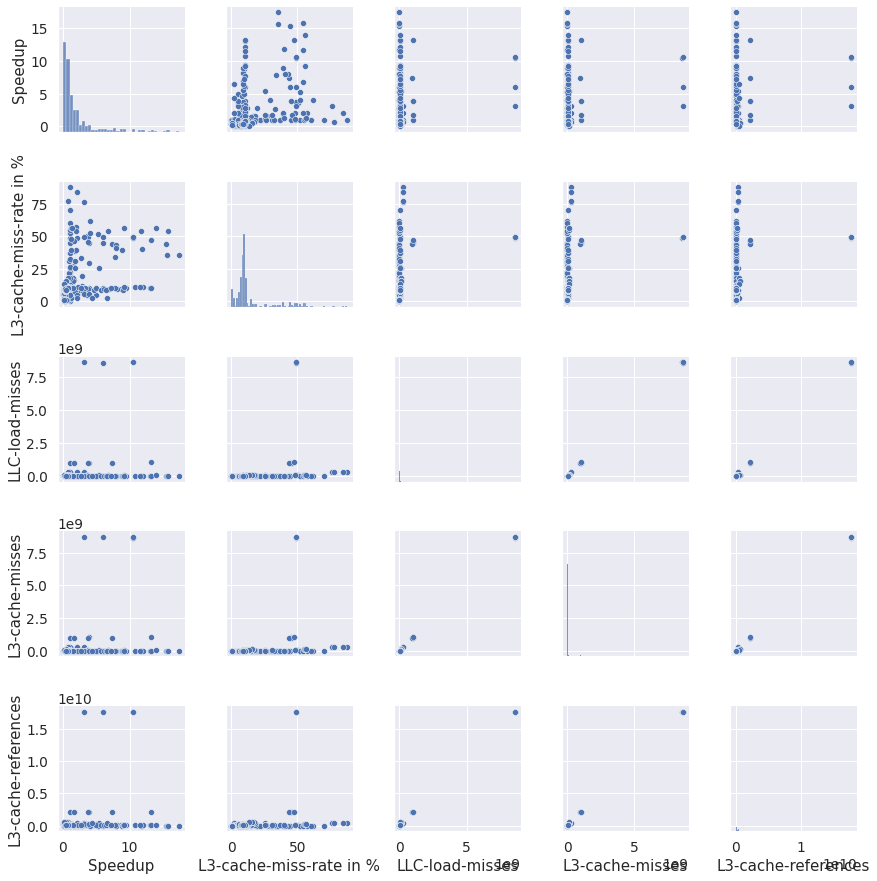

In [34]:
sns.pairplot(df[cols[0:5]])

In [35]:
scaler = StandardScaler().fit(X)
X_standardized = pd.DataFrame(scaler.transform(X),
                              columns = X.columns)
X_standardized.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time
0,0.446636,1.060636,-0.375865,1.038565,-0.134563,-0.329654,-0.131487,-0.160461,-0.271233,-0.768126,-0.160232,0.257209,-0.230083,0.474806,-0.133920,-0.320181
1,0.446636,1.210202,-0.377614,1.105175,-0.134747,-0.369756,-0.129447,-0.162224,-0.270362,-0.668892,-0.162201,0.208711,-0.229271,0.580988,-0.133735,-0.320339
2,0.446636,-1.088063,-0.371858,0.973620,-0.133832,-0.334001,-0.127701,-0.160541,-0.270777,-0.766657,-0.160457,0.256604,-0.229194,0.606329,-0.133894,-0.315975
3,0.700424,1.210202,-0.442473,-1.545831,-0.143883,1.215819,-0.175875,-0.182222,-0.300135,0.078696,-0.181406,-0.861900,-0.259309,-1.060430,-0.143420,0.010764
4,-0.822304,-0.055210,-0.082852,0.003833,-0.134348,-0.657973,-0.083410,-0.101599,-0.103405,-0.123985,-0.101187,0.264873,-0.090815,0.906533,-0.133887,-0.164733


In [36]:
X_train_std, X_test_std, Y_train_std, Y_test_std = train_test_split(X_standardized, Y, test_size=0.2, random_state=5)

In [37]:
ANN_model = Sequential()

ANN_model.add(Dense(16, kernel_initializer='normal',input_dim = X_train_std.shape[1], activation='relu'))

ANN_model.add(Dense(16, kernel_initializer='normal',activation='relu'))
ANN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
ANN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))

ANN_model.add(Dense(1, kernel_initializer='normal'))

ANN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [38]:
checkpoint = ModelCheckpoint('Weights-{epoch:03d}--{val_loss:.4f}.hdf5', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
ANN_model.fit(X_train_std, Y_train_std, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/100
1/7 [===>..........................] - ETA: 6s - loss: 3.1402 - mean_absolute_error: 3.1402
Epoch 00001: val_loss improved from inf to 2.21076, saving model to Weights-001--2.2108.hdf5
7/7 [==============================] - 1s 44ms/step - loss: 2.2915 - mean_absolute_error: 2.2915 - val_loss: 2.2108 - val_mean_absolute_error: 2.2108
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 1.8365 - mean_absolute_error: 1.8365
Epoch 00002: val_loss improved from 2.21076 to 2.20288, saving model to Weights-002--2.2029.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 2.2839 - mean_absolute_error: 2.2839 - val_loss: 2.2029 - val_mean_absolute_error: 2.2029
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 2.8933 - mean_absolute_error: 2.8933
Epoch 00003: val_loss improved from 2.20288 to 2.19440, saving model to Weights-003--2.1944.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 2.2758 - mean_absolute_error: 2.2758 - va

In [39]:
pred = ANN_model.predict(X_test_std)
print("Artificial Neural Network Mean Absolute Error: ", mae(Y_test_std, pred))
print("R2 score using ANN: ", r2_score(Y_test_std, pred))

Artificial Neural Network Mean Absolute Error:  1.3164015240647196
R2 score using ANN:  0.053542491187745234


In [40]:
scaler_smogn = StandardScaler().fit(X_smogn)
X_smogn_standardized = pd.DataFrame(scaler_smogn.transform(X_smogn),
                              columns = X_smogn.columns)
X_smogn_standardized.head()

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time
0,-0.901611,1.288039,-0.357983,-1.562463,-0.092164,1.881615,-0.112322,-0.126787,-0.148741,-0.374944,-0.127419,-0.660151,-0.116390,-0.922370,-0.091013,-0.068436
1,-0.635092,1.288039,-0.323165,-1.622742,-0.091920,1.897756,-0.112417,-0.132556,-0.145724,-0.167190,-0.132903,-0.657800,-0.120818,-0.923017,-0.090688,-0.122445
2,-0.102053,1.288039,-0.322253,-1.628770,-0.090791,1.938857,-0.112142,-0.130175,-0.145749,-0.229516,-0.130532,-0.664324,-0.120169,-0.923923,-0.089795,-0.146395
3,0.964024,1.288039,-0.321150,-1.628770,-0.084538,2.244628,-0.112262,-0.128674,-0.144982,-0.271067,-0.129199,-0.664245,-0.118724,-0.923932,-0.083254,-0.158712
4,3.096178,1.288039,-0.317926,-1.628770,-0.082416,2.344351,-0.112223,-0.128142,-0.144485,-0.291843,-0.128576,-0.664081,-0.118289,-0.922747,-0.081053,-0.166603


In [41]:
X_train_smogn_std, X_test_smogn_std, Y_train_smogn_std, Y_test_smogn_std = train_test_split(X_smogn_standardized, Y_smogn, test_size=0.2, random_state=5)

In [42]:
ANN_smogn_model = Sequential()

ANN_smogn_model.add(Dense(16, kernel_initializer='normal',input_dim = X_train_smogn_std.shape[1], activation='relu'))

ANN_smogn_model.add(Dense(16, kernel_initializer='normal',activation='relu'))
ANN_smogn_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
ANN_smogn_model.add(Dense(8, kernel_initializer='normal',activation='relu'))

ANN_smogn_model.add(Dense(1, kernel_initializer='normal'))

ANN_smogn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [43]:
checkpoint_smogn = ModelCheckpoint('Weights-SMOGN-{epoch:03d}--{val_loss:.4f}.hdf5', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list_smogn = [checkpoint_smogn]
ANN_model.fit(X_train_smogn_std, Y_train_smogn_std, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list_smogn)

Epoch 1/100
1/7 [===>..........................] - ETA: 0s - loss: 1.3111 - mean_absolute_error: 1.3111
Epoch 00001: val_loss improved from inf to 0.97702, saving model to Weights-SMOGN-001--0.9770.hdf5
7/7 [==============================] - 0s 24ms/step - loss: 1.1055 - mean_absolute_error: 1.1055 - val_loss: 0.9770 - val_mean_absolute_error: 0.9770
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6009 - mean_absolute_error: 0.6009
Epoch 00002: val_loss improved from 0.97702 to 0.96382, saving model to Weights-SMOGN-002--0.9638.hdf5
7/7 [==============================] - 0s 12ms/step - loss: 1.0857 - mean_absolute_error: 1.0857 - val_loss: 0.9638 - val_mean_absolute_error: 0.9638
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 1.1599 - mean_absolute_error: 1.1599
Epoch 00003: val_loss improved from 0.96382 to 0.95568, saving model to Weights-SMOGN-003--0.9557.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 1.0632 - mean_absolute_

In [44]:
pred_smogn = ANN_smogn_model.predict(X_test_smogn_std)
print("Artificial Neural Network SMOGN Mean Absolute Error: ", mae(Y_test_smogn_std, pred_smogn))
print("R2 score using SMOGN ANN: ", r2_score(Y_test_smogn_std, pred_smogn))

Artificial Neural Network SMOGN Mean Absolute Error:  1.5641698153488666
R2 score using SMOGN ANN:  -0.6088918604920808
